# Compares calibration methods (Only lifetime with Lifetime+geometry)

### JAH 04/08/18 

<i>
This notebook compares two calibrations methods: Gonzalo's based on a lifetime fit and them a refined geometry map with smaller bin pitches, and only lifetime map with fine bin pitches.
</i>

In [2]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug  4 22:40:46 2018


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [4]:
run_number                 = 6206
multiple_kdsts             = True
input_dst_filenames        = [f"$IC_DATA/dsts/kdst_{run_number}_0_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_1_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_2_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_3_filtered.h5"
                             ]
run_number_correction      = 6206
correction_filename        = f"$IC_DATA/maps/akr_corrections_run{run_number_correction}.h5"

apply_geocorrection = True

Rrange  =    0., 200.
Zrange  =    0., 550.
XYrange = -200., 200.
E0range = 7.5e3, 13.5e3
LTrange = 1.5e3,  3.0e3

XYnbins      =  100


### Imports

In [5]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf

from invisible_cities.core .core_functions import in_range
from   invisible_cities.evm  .ic_containers  import Measurement

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.dev.akr_functions          as akr
import krcal.dev.corrections            as corrections
import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf


In [6]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [7]:
input_dst_filenames = [os.path.expandvars(fi) for fi in input_dst_filenames]
correction_filename = os.path.expandvars(correction_filename)

In [8]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [9]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 4534806 
Total number of events: 4534806


## Relevant data and corrections

In [10]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
#TD  = np.array([datetime.datetime.fromtimestamp(itime) for itime in T])
TH  = (T - T.min())/3600. # time in hours


In [11]:
sel_r = in_range(R, *Rrange)
sel_z = in_range(Z, *Zrange)
sel   = sel_r & sel_z

In [12]:
calibrate = corrections.Calibration(correction_filename, 'scale')
E, Q = calibrate(X, Y, Z, T, S2e, S2q)

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/akr_corrections_run6206.h5
node             : scale


In [13]:
def plt_eresolution_fid(V, Vnbins, Vrange):
    plt_energy(V[sel]    , Vnbins, Vrange, label = '$R < 200, Z < 550$')

    sel_ri = in_range(R, 0., 150.)
    sel_zi = in_range(Z, 0., 250.)
    sel_fid = sel & sel_ri & sel_zi
    plt_energy(V[sel_fid], Vnbins, Vrange, label= '$R < 150, Z < 250$')
    return

In [14]:
Ea = hst.Vaxis((11e3, 13.5e3), 100)

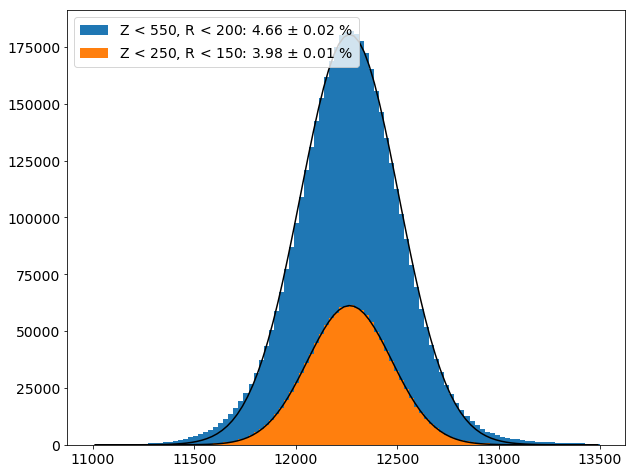

In [15]:
apt.plt_energy(E, Ea.bins, label = 'Z < 550, R < 200')
sel_fid = in_range(R, 0., 150) & in_range(Z, 0., 250.)
apt.plt_energy(E[sel_fid], Ea.bins, label = 'Z < 250, R < 150')

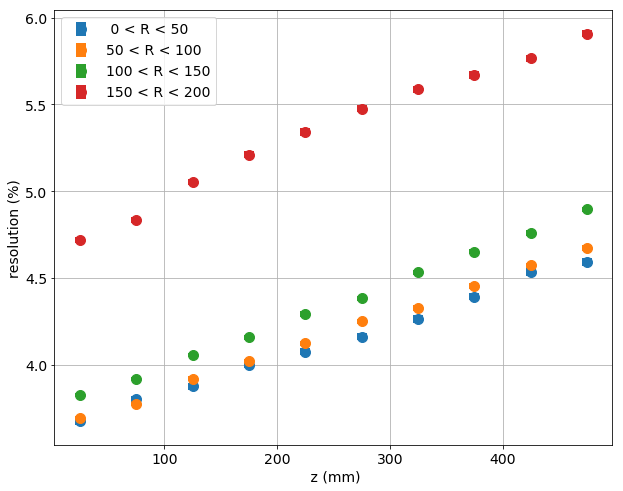

In [16]:
Ra = hst.Vaxis((0., 201.), step = 50)
Za = hst.Vaxis((0., 501.), step = 50)

apt.plt_eresolution_zr(E, R, Z, Ea.nbins, Ea.range, Ra.bins, Za.bins)

## Compare with Gonzalo's

In [17]:
correction_filename = f"$IC_DATA/maps/corrections_run{run_number_correction}.h5"
correction_filename = os.path.expandvars(correction_filename)

In [18]:
gcalibrate = corrections.Calibration(correction_filename, 'geometry')
E2, Q2 = gcalibrate(X, Y, Z, T, S2e, S2q)

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/corrections_run6206.h5
node             : geometry


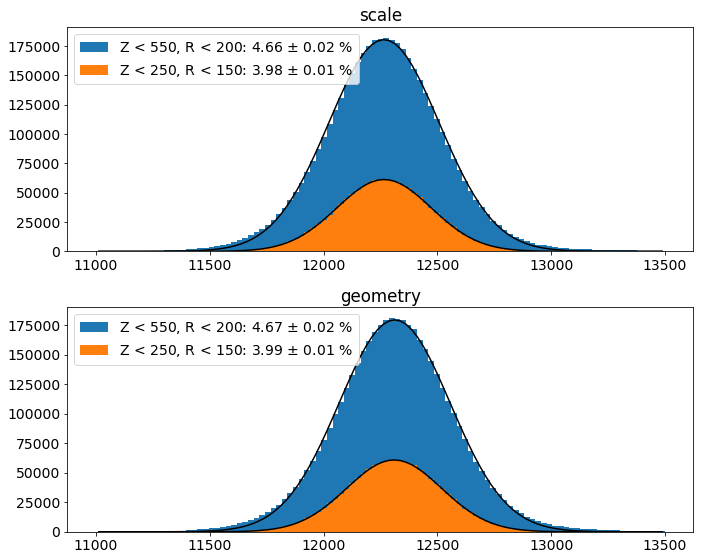

In [19]:
plt.subplot(2, 1, 1)
apt.plt_energy(E, Ea.bins, label = 'Z < 550, R < 200')
sel_fid = in_range(R, 0., 150) & in_range(Z, 0., 250.)
apt.plt_energy(E[sel_fid], Ea.bins, label = 'Z < 250, R < 150')
plt.title('scale')
plt.subplot(2, 1, 2)
apt.plt_energy(E2, Ea.bins, label = 'Z < 550, R < 200')
sel_fid = in_range(R, 0., 150) & in_range(Z, 0., 250.)
apt.plt_energy(E2[sel_fid], Ea.bins, label = 'Z < 250, R < 150')
plt.title('geometry')
plt.tight_layout()

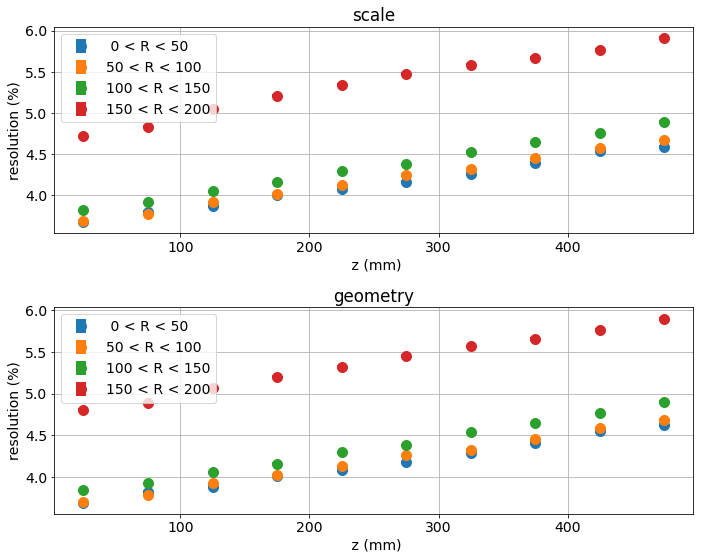

In [20]:
plt.subplot(2, 1, 1)
apt.plt_eresolution_zr(E, R, Z, Ea.nbins, Ea.range, Ra.bins, Za.bins)
plt.title('scale')
plt.subplot(2, 1, 2)
apt.plt_eresolution_zr(E2, R, Z, Ea.nbins, Ea.range, Ra.bins, Za.bins)
plt.title('geometry')
plt.tight_layout()

In [21]:
print('Done!')

Done!
